# Projet_ED2
Projet de Mathématiques - Équations Différentielles II

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Jusqu'à présent, on a présenté des schémas dépendant de pas de temps $\Delta t_j$, sans jamais dire comment les choisir. Le plus simple est de choisir un pas $\Delta t$ fixe mais il est difficile de savoir à l'avance quel pas est nécessaire. En particulier, comment savoir si la solution obtenue est suffisamment précise, sans connaître la vraie ?

## Pas fixe

Une voie empirique est de fixer un pas, lancer la simulation, puis fixer un pas plus petit, relancer la simulation, jusqu'à ce que les resultats ne semble plus changer (au sens de ce qui nous intéresse d'observer). Notons que la connaissance des constantes de temps présentes dans le système peut aider à fixer un premier ordre de grandeur du pas. On pourrait aussi directement choisir le pas $\Delta t_{opt}$ obtenu plus haut en prenant en compte les erreurs d'arrondis. Mais les constantes $c_v$ et $S(T)$ sont souvent mal connues et conservatives.

### Consigne
Coder une fonction

`def solve_euler_explicit(f, x0, dt):
...
return (t, x)`

prenant en entrée une fonction $f$, une condition initiale $x_0$ et un pas de temps $dt$, et renvoyant le vecteur des temps $t^j$ et de la solution $x^j$ du schéma d'Euler explicite appliqué à $\dot{x}=f(x)$. Tester les performances de votre solver sur une équation différentielle que vous savez résoudre. Illustrer la convergence du schéma à l'ordre 1.

#### Remarque
On rajoute un argument `tf` correspondant au temps final de la simulation (en sous entendant un départ à $x_0$ en $t = 0$)

In [2]:
def solve_euler_explicit(f, x0, dt, tf):
    n = int(tf//dt) #Nombre de passage dans la boucles
    t, x = np.empty(n), np.empty((n,x0.shape[0])) #On intialise des tableaux vides. 
    #Le temps est forcément un vecteur, alors que x peut être une matrice comme x0 peut avoir plusieurs coordonées.
    x[0] = x0 #On fixe la valeur de x0 (t0 étant déjà par défaut à 0)
    
    for i in range(n-1):
        t[i+1], x[i+1] = t[i] + dt, x[i] + f(x[i])*dt
    return (t,x)

#### Illustration du schéma
On illustre le schéma avec deux équations différentielles simples :
- $\dot{x} = x$ et $x_0 = 1$, qui se résout en $x = exp$. On a alors $f : x \mapsto x$
- $\ddot{x} + x = 0$ et $(x_0, v_0) = (0,1)$, qui se résout en $x = sin$. On a alors $f = \begin{pmatrix}
0 & -1 \\
1 & 0
\end{pmatrix}$, ou autrement $f : (x_1,x_2) \mapsto (x_2, -x_1)$

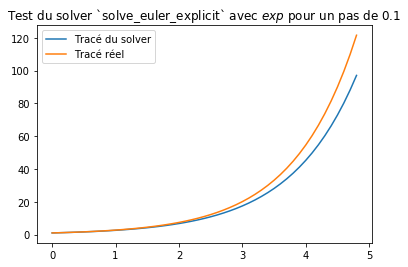

24.49318373386258

In [3]:
#Exponentielle
T, X = solve_euler_explicit(lambda x: x, np.array([1]), 10**-1, 5)
X_Theo = np.exp(T)
plt.plot(T,X, label="Tracé du solver")
plt.plot(T,X_Theo, label="Tracé réel")
plt.title("Test du solver `solve_euler_explicit` avec $exp$ pour un pas de 0.1")
plt.legend()
plt.show()
max(abs(X_Theo-X[:,0]))

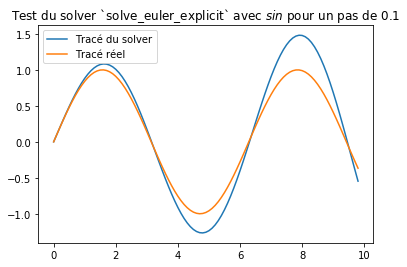

In [4]:
#Sinus
T, Y = solve_euler_explicit(lambda X: np.array((X[1],-X[0])), np.array([0,1]), 10**-1, 10)
X = Y[:,0] #On ne récupère que la position
X_Theo = np.sin(T)
plt.plot(T,X, label="Tracé du solver")
plt.plot(T,X_Theo, label="Tracé réel")
plt.title("Test du solver `solve_euler_explicit` avec $sin$ pour un pas de 0.1")
plt.legend()
plt.show()

#### Mise en évidence de l'ordre 1
La définition de la convergence d'une méthode d'ordre $p$ est la suivante :
$$ E_{\Delta t} = \max_{1 \leq j \leq J} |x^j - x(t_j)| \leq c_v (\Delta t)^{p} $$
Autrement dit dans le cas de l'ordre 1, la plus grosse erreur absolue en un temps donné est toujours inférieur à $\Delta t$ multiplié par une constante $c_v$, qui est indépendante de $\Delta t$.

On se propose donc de définir une fonction `E` qui en prenant comme paramètre $\Delta t$ retourne la plus grande erreur absolue $E_{\Delta t}$.

On trace alors $E_{\Delta t}$ pour différentes valeur de $\Delta t$ et l'on vérifie que l'erreur se comporte linéairement, traduisant l'ordre 1.

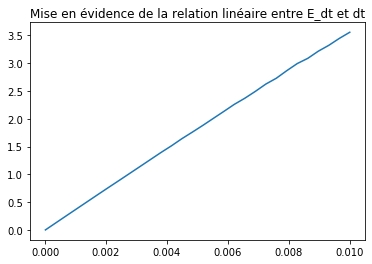

In [5]:
def E(dt):
    T, X = solve_euler_explicit(lambda x: x, np.array([1]), dt, 5)
    X_Theo = np.exp(T)
    return max(abs(X_Theo-X[:,0]))

DT = np.linspace(10**-5, 10**-2, 30)
Ev = np.vectorize(E)
plt.plot(DT, Ev(DT))
plt.title("Mise en évidence de la relation linéaire entre E_dt et dt")
plt.show()

### Consigne
Faire de même et comparer la convergence avec un schéma d'ordre 2 de votre choix.

## Adaptation du pas de temps

Les méthodes à pas fixe exploitent la convergence des schémas, mais :
- on ne peut pas prendre un pas de temps arbitrairement petit car on est contraint par le temps de simulation.
- on n'a aucune idée de l'erreur commise et on n'est jamais sûr d'avoir la bonne solution.
- l'utilisation d'un pas très petit peut n'être nécessaire qu'autour de certains points sensibles (proches de singularités par exemple) et consomme des ressources inutiles ailleurs.

L'idée serait donc plutôt d'adapter la valeur du pas $\Delta t_j$ à chaque itération. En d'autres termes, on se fixe une tolérance d'erreur que l'on juge acceptable et on modifie le pas de temps en ligne, selon si l'on estime être au-dessus ou en-dessous du seuil d'erreur. Mais cela suppose d'avoir une idée de l'erreur commise... Il existe justement des moyens de l'estimer.

Tout d'abord, de quelle erreur parle-t-on ?
- erreur globale ? L'idéal serait de contrôler $\max_{0\leq j\leq N} ||x^j - x(t_j)||$. Or la stabilité nous dit que $$ \max_{0\leq j\leq N} ||x^j - x(t_j)|| \leq S(T) , \sum_{j = 1}^J \Delta t_{j-1}, ||\eta^j|| $$ avec $\eta^j$ les erreurs de consistances locales. Donc si on se fixe une tolérance sur l'erreur globale $\texttt{Tol}_g$, on a $$ ||\eta^j|| \leq \frac{\texttt{Tol}_g}{TS(T)} \qquad \Longrightarrow \qquad \max{0\leq j\leq N} ||x^j - x(t_j)|| \leq \texttt{Tol}_g \ . $$ En d'autre termes, $\texttt{Tol}_g$ nous fixe une erreur maximale locale sur $\eta^j$, à chaque itération. Notons cependant que cette borne ne prend pas en compte la propagation des erreurs d'arrondis : plus $\Delta t$ diminue, plus l'erreur globale risque d'augmenter. Ce phénomène devrait donc en toute rigueur aussi nous donner un pas de temps minimal $\Delta t_{\min}$. Notons que tous ces calculs dépendent des constantes $c_v$ et $S(T)$ qui sont souvent mal connues ou très conservatives.
- erreur (absolue) locale ? A chaque itération, une erreur locale est commise dûe à l'approximation de l'intégrale. Cette erreur est donnée par $$ e^{j+1} = \left(x^j + \int_{t_j}^{t_{j+1}} f(s,x(s))ds\right) -x^{j+1} $$ où le premier terme représente la valeur de la vraie solution au temps $t_{j+1}$ si elle était initialisée à $x^j$ au temps $t_j$.
Notons que si on avait $x^j=x(t_j)$, on aurait exactement $e^{j+1}=\Delta t_j \eta^{j+1}$, où $\eta^{j+1}$ est l'erreur de consistance.
On se donne donc une tolérance d'erreur locale $$ ||e^{j+1}|| \leq \texttt{Tol}_{abs} \ . $$
- erreur relative ? Fixer une erreur absolue est parfois trop contraignant et n'a de sens que si les solutions gardent un certain ordre de grandeur. En effet, l'erreur acceptable quand la solution vaut 1000 n'est peut-être pas la même que lorsqu'elle vaut 1. On peut donc plutôt exiger une certaine erreur relative $\texttt{Tol}_{rel}$, i.e., $$ \frac{||e^{j+1}||}{||x^j||}\leq \texttt{Tol}_{rel} \ . $$
En général, les solvers assurent (approxivement) $$ ||e^{j+1}|| \leq \texttt{Tol}_{abs} + \texttt{Tol}_{rel} ||x^j|| \ . $$ Par défaut, dans les solvers de Numpy, $\texttt{Tol}_{abs} = 10^{-6}$ et $\texttt{Tol}_{rel}= 10^{-3}$.

Mais pour cela nous devons trouver un moyen d'estimer l'erreur locale. C'est souvent fait en utilisant une même méthode à deux pas différents (par exemple $\Delta t_j$ et $\Delta t_j/2$), ou bien en imbriquant des schémas de Runge-Kutta d'ordres différents.

### Consigne
Montrer que si $f$ est $C^1$, on a pour un schéma d'Euler explicite $$ ||e^{j+1}|| = \Delta t \frac{\big|f(t_{j+1},x^{j+1}) - f(t_j,x^j)\big|}{2} + O(\Delta t_j^3) \ $$

On peut donc estimer à chaque itération l'erreur commise $e^{j+1}$ et adapter le pas selon si celle-ci est inférieure ou supérieure au seuil de tolérance.

### Consigne
En justifiant que par ailleurs $e^{j+1} = O(\Delta t_j^2)$, en déduire qu'une possible stratégie d'adaptation est de prendre
$$ \Delta t_{new} = \Delta t \sqrt{\frac{\texttt{Tol}_{abs}}{||e^{j+1}||}} $$ (éventuellement avec une marge de sécurité).

La fonction correspondante

`def solve_euler_explicit_variable_step(f, x0, t0, tf, dtmin, dtmax, atol):
...
return (t, x)`

est fourni dans le notebook Equations Differentielles II.ipynb.

### Consigne
Expliquer et illustrer le fonctionnement de ce solveur.